In [1]:
import pyarrow.dataset as ds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
from statsmodels.stats import stattools
from scipy import stats
import seaborn as sns

In [3]:
from RiskLabAI.controller import Controller
# initialize controller
controller = Controller()

In [4]:
import optuna
from optuna.samplers import TPESampler
from optuna.exceptions import TrialPruned
import torch
print(torch.backends.mps.is_available())

True


# Load Datasets

In [5]:
#Asset under study
ticker = 'BTCUSDT'

# define dataset
dataset = ds.dataset(
    "/Users/bobet/Documents/Code Repository/Trading-Systems/_datasets",
    format="parquet")

# push filter into Arrow scan (faster, uses partition pruning if possible)
table = dataset.to_table(filter=ds.field("symbol") == ticker)

# convert to pandasssss
df = table.to_pandas()
df.tail()

,symbol,ts_ms,iso_utc,ohlc_ts_open,ohlc_open,ohlc_high,ohlc_low,ohlc_close,ohlc_volume,ohlc_ts_close,...,tr_volume_base,tr_volume_quote,tr_vwap,tr_buy_sell_imbalance,spot_price,perp_mark_price,basis_abs,basis_pct,funding_rate,next_funding_time_ms
37904,BTCUSDT,1757746196882,2025-09-13T06:49:56.882944+00:00,1757746140000,115693.77,115693.77,115675.91,115675.91,8.29132,1757746199999,...,13.40075,1.550572e+06,115707.874085,-0.635128,115675.91,115617.10000,-58.81000,-0.000508,0.000035,1757750400000
37905,BTCUSDT,1757746256932,2025-09-13T06:50:56.932928+00:00,1757746200000,115675.92,115675.92,115675.91,115675.91,0.85015,1757746259999,...,9.89241,1.144571e+06,115701.902799,-0.123805,115675.92,115627.50000,-48.42000,-0.000419,0.000034,1757750400000
37906,BTCUSDT,1757746316982,2025-09-13T06:51:56.982649+00:00,1757746260000,115675.92,115714.01,115675.91,115714.00,4.98386,1757746319999,...,21.91183,2.535333e+06,115706.112903,-0.572355,115714.01,115663.23979,-50.77021,-0.000439,0.000034,1757750400000
37907,BTCUSDT,1757746377032,2025-09-13T06:52:57.032633+00:00,1757746320000,115714.01,115714.01,115714.00,115714.00,1.29278,1757746379999,...,22.80020,2.637930e+06,115697.670905,-0.942235,115714.00,115666.70000,-47.30000,-0.000409,0.000034,1757750400000
37908,BTCUSDT,1757746437082,2025-09-13T06:53:57.082743+00:00,1757746380000,115714.00,115714.01,115714.00,115714.01,4.57517,1757746439999,...,10.47169,1.211363e+06,115679.782389,-0.634972,115714.00,115669.50000,-44.50000,-0.000385,0.000034,1757750400000


In [6]:
#features
df.columns

Index(['symbol', 'ts_ms', 'iso_utc', 'ohlc_ts_open', 'ohlc_open', 'ohlc_high',
       'ohlc_low', 'ohlc_close', 'ohlc_volume', 'ohlc_ts_close', 'ohlc_trades',
       'ohlc_taker_base', 'ohlc_taker_quote', 'l1_bid', 'l1_ask', 'l1_mid',
       'l1_spread', 'l1_bid_qty', 'l1_ask_qty', 'l1_imbalance', 'l2_bid_depth',
       'l2_ask_depth', 'l2_depth_asymmetry', 'l2_bid_vwap', 'l2_ask_vwap',
       'l2_bid_slope', 'l2_ask_slope', 'tr_volume_base', 'tr_volume_quote',
       'tr_vwap', 'tr_buy_sell_imbalance', 'spot_price', 'perp_mark_price',
       'basis_abs', 'basis_pct', 'funding_rate', 'next_funding_time_ms'],
      dtype='object')

In [7]:
sample_size = df.count()[0]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37909 entries, 0 to 37908
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   symbol                 37909 non-null  object 
 1   ts_ms                  37909 non-null  int64  
 2   iso_utc                37909 non-null  object 
 3   ohlc_ts_open           37909 non-null  int64  
 4   ohlc_open              37909 non-null  float64
 5   ohlc_high              37909 non-null  float64
 6   ohlc_low               37909 non-null  float64
 7   ohlc_close             37909 non-null  float64
 8   ohlc_volume            37909 non-null  float64
 9   ohlc_ts_close          37909 non-null  int64  
 10  ohlc_trades            37909 non-null  int64  
 11  ohlc_taker_base        37909 non-null  float64
 12  ohlc_taker_quote       37909 non-null  float64
 13  l1_bid                 37909 non-null  float64
 14  l1_ask                 37909 non-null  float64
 15  l1

## Raw Features

### General
- **symbol**: Trading pair identifier (e.g., BTCUSDT).  
- **ts_ms**: Data timestamp in milliseconds (epoch time).  
- **iso_utc**: Data timestamp in human-readable UTC format.  

### OHLC Data (Candlestick)
- **ohlc_ts_open**: Opening timestamp for the candlestick period.  
- **ohlc_open**: Opening price of the candlestick.  
- **ohlc_high**: Highest price within the candlestick.  
- **ohlc_low**: Lowest price within the candlestick.  
- **ohlc_close**: Closing price of the candlestick.  
- **ohlc_volume**: Trading volume during the candlestick (base asset units).  
- **ohlc_ts_close**: Closing timestamp for the candlestick period.  
- **ohlc_trades**: Number of trades in the candlestick.  
- **ohlc_taker_base**: Base asset volume traded by takers (aggressors).  
- **ohlc_taker_quote**: Quote asset volume traded by takers.  

### Level 1 Order Book (Top of Book)
- **l1_bid**: Best bid price (highest buy order).  
- **l1_ask**: Best ask price (lowest sell order).  
- **l1_mid**: Midpoint price between bid and ask.  
- **l1_spread**: Difference between best ask and bid (ask - bid).  
- **l1_bid_qty**: Quantity available at best bid.  
- **l1_ask_qty**: Quantity available at best ask.  
- **l1_imbalance**: Order book imbalance at Level 1 = (bid_qty – ask_qty) / (bid_qty + ask_qty).  

### Level 2 Order Book (Depth of Market)
- **l2_bid_depth**: Total buy-side liquidity across multiple bid levels.  
- **l2_ask_depth**: Total sell-side liquidity across multiple ask levels.  
- **l2_depth_asymmetry**: Relative difference between bid and ask depth.  
- **l2_bid_vwap**: Volume-weighted average bid price across order book levels.  
- **l2_ask_vwap**: Volume-weighted average ask price across order book levels.  
- **l2_bid_slope**: Measure of how steeply bid prices rise with quantity (liquidity gradient).  
- **l2_ask_slope**: Measure of how steeply ask prices rise with quantity.  

### Trade Data
- **tr_volume_base**: Total traded volume in base asset.  
- **tr_volume_quote**: Total traded volume in quote asset.  
- **tr_vwap**: Trade volume-weighted average price.  
- **tr_buy_sell_imbalance**: Difference between buy-initiated and sell-initiated trade volumes.  

### Derived Prices
- **spot_price**: Current spot market price.  
- **perp_mark_price**: Mark price used in perpetual futures to avoid manipulation.  
- **basis_abs**: Absolute difference between perpetual mark price and spot price.  
- **basis_pct**: Percentage difference between perpetual mark price and spot price.  
- **funding_rate**: Periodic payment rate between long and short positions in perpetual contracts.  
- **next_funding_time_ms**: Timestamp (ms) of the next funding event.  

## Data hygiene & storage

✔ Why: storage efficiency + ordering. A 10GB dataset may shrink to ~3-4GB when optimized.

In [8]:
# Ensure correct dtypes (saves memory on 10GB dataset)
dtype_map = {
    "symbol": "category",
    "ohlc_open": "float32", "ohlc_high": "float32", "ohlc_low": "float32", "ohlc_close": "float32",
    "ohlc_volume": "float32", "ohlc_trades": "int32",
    "ohlc_taker_base": "float32", "ohlc_taker_quote": "float32",
    "l1_bid": "float32", "l1_ask": "float32", "l1_mid": "float32", "l1_spread": "float32",
    "l1_bid_qty": "float32", "l1_ask_qty": "float32", "l1_imbalance": "float32",
    "l2_bid_depth": "float32", "l2_ask_depth": "float32", "l2_depth_asymmetry": "float32",
    "l2_bid_vwap": "float32", "l2_ask_vwap": "float32",
    "l2_bid_slope": "float32", "l2_ask_slope": "float32",
    "tr_volume_base": "float32", "tr_volume_quote": "float32", "tr_vwap": "float32",
    "tr_buy_sell_imbalance": "float32",
    "spot_price": "float32", "perp_mark_price": "float32",
    "basis_abs": "float32", "basis_pct": "float32", "funding_rate": "float32"
}

df = df.astype(dtype_map)

# Make sure timestamp is datetime
df["iso_utc"] = pd.to_datetime(df["iso_utc"])
df = df.set_index("iso_utc").sort_index()


#Intergrity Check
# Drop duplicates, check ordering
df = df[~df.index.duplicated(keep="first")].sort_index()

# Sanity checks for OHLC
mask = (
    (df["ohlc_low"] <= df["ohlc_open"]) &
    (df["ohlc_low"] <= df["ohlc_close"]) &
    (df["ohlc_high"] >= df["ohlc_open"]) &
    (df["ohlc_high"] >= df["ohlc_close"])
)
df = df[mask]

# Check non-negative volumes
df = df[df["ohlc_volume"] >= 0]

## Convert DataFrame to RiskLA AI Input Format

In [9]:
df_riskAI = df.copy()
df_riskAI = df_riskAI.loc[:, ['symbol', 'ohlc_close', 'ohlc_volume']]
#rename column
df_riskAI.reset_index(inplace=True) 
df_riskAI.set_index('symbol', inplace=True)
df_riskAI.columns = ['date', 'price', 'volume']
df_riskAI.head()

,date,price,volume
symbol,,,
BTCUSDT,2025-08-17 15:45:47.575950+00:00,118251.351562,0.75580
BTCUSDT,2025-08-17 15:46:47.606265+00:00,118234.531250,5.14589
BTCUSDT,2025-08-17 15:47:47.643040+00:00,118234.531250,2.35213
BTCUSDT,2025-08-17 15:48:47.662644+00:00,118234.523438,6.03409
BTCUSDT,2025-08-17 15:49:47.702649+00:00,118234.523438,1.28289


## Load Existing Parameter Resampling Database

In [10]:
param_db_filename = 'params_resampling-scheme.json'
# Open and load JSON file

def load_param_resampling_db(file_name):
    """
    Load resampling parameter database from a JSON file.

    Parameters
    ----------
    file_name : str
        Path to the JSON file containing the parameter database.

    Returns
    -------
    list of dict
        A list of parameter dictionaries previously stored.
        If the file does not exist or is invalid, returns an empty list.

    Notes
    -----
    - The expected structure is a list of dictionaries where each dictionary
      contains keys such as 'Sampling_Scheme', 'n_trials', 'n_samples', etc.
    - Use together with `sampling_best_params` for managing optimal bar parameters.

    Examples
    --------
    >>> params_db = load_param_resampling_db("params_resampling-scheme.json")
    >>> len(params_db)
    5
    """
    with open(file_name, "r") as f:
        df_params = json.load(f)
    return df_params

db_resampling_params = load_param_resampling_db(param_db_filename)
db_resampling_params

[{'ticker': 'BTCUSDT',
  'Sampling_Scheme': 'expected_tick_imbalance_bars',
  'n_trials': 50,
  'n_samples': 29401,
  'Shapiro-Wilk_statistic': 0.860134363,
  'Shapiro-Wilk_pvalue': 0.0,
  'window_size_for_expected_n_ticks_estimation': 5,
  'window_size_for_expected_imbalance_estimation': 10000,
  'initial_estimate_of_expected_n_ticks_in_bar': 20000,
  'batch_size': 1000000},
 {'ticker': 'BTCUSDT',
  'Sampling_Scheme': 'expected_volume_imbalance_bars',
  'n_trials': 50,
  'n_samples': 29401,
  'Shapiro-Wilk_statistic': 0.966333091,
  'Shapiro-Wilk_pvalue': 0.870860279,
  'window_size_for_expected_n_ticks_estimation': 5,
  'window_size_for_expected_imbalance_estimation': 10000,
  'initial_estimate_of_expected_n_ticks_in_bar': 20000,
  'batch_size': 1000000},
 {'ticker': 'BTCUSDT',
  'Sampling_Scheme': 'expected_dollar_imbalance_bars',
  'n_trials': 50,
  'n_samples': 29401,
  'Shapiro-Wilk_statistic': 0.961657166,
  'Shapiro-Wilk_pvalue': 0.832820237,
  'window_size_for_expected_n_ticks

In [11]:
#load best parameters in the resampling database
def db_resampling_best_params(_sampling_method,db_params):
    """
    Retrieve the best parameter set for a given resampling method
    from the parameter database.

    Parameters
    ----------
    _sampling_method : str
        The sampling scheme to filter on, e.g.:
        - "expected_tick_imbalance_bars"
        - "expected_volume_run_bars"
    db_params : list of dict
        The resampling parameter database, typically loaded from JSON.

    Returns
    -------
    dict
        The best parameter dictionary for the given sampling scheme.

    Notes
    -----
    - Ranking is based on three criteria:
        1. `n_samples` (ascending) → prefer larger sample size.
        2. `Shapiro-Wilk_pvalue` (ascending).
        3. `Shapiro-Wilk_statistic` (ascending).
    - The last row after sorting is returned (`tail(1)`), so effectively it picks 
      the parameters with *highest* sample size, *highest* p-value, and *highest* statistic.

    Examples
    --------
    >>> best = db_resampling_best_params("expected_tick_imbalance_bars", params_db)
    >>> best["n_samples"]
    25000
    """
    db = pd.DataFrame(db_params)
    db = db.loc[db['Sampling_Scheme'] ==_sampling_method]

    # Sort by 'n_samples' first, then by 'Shapiro-Wilk_pvalue', then by 'Shapiro-Wilk_statistic'
    db = db.sort_values(
        by=['n_samples', 'Shapiro-Wilk_pvalue', 'Shapiro-Wilk_statistic'],
        ascending=[True, True, True])   # example: n_samples ↑, pvalue ↓, stat ↓

    return db.tail(1).to_dict(orient="records")[0]

In [12]:
db_best_params = db_resampling_best_params(_sampling_method='expected_dollar_imbalance_bars',db_params=db_resampling_params)
db_best_params

{'ticker': 'BTCUSDT',
 'Sampling_Scheme': 'expected_dollar_imbalance_bars',
 'n_trials': 200,
 'n_samples': 37909,
 'Shapiro-Wilk_statistic': 1.0,
 'Shapiro-Wilk_pvalue': 1.0,
 'window_size_for_expected_n_ticks_estimation': 10,
 'window_size_for_expected_imbalance_estimation': 1614,
 'initial_estimate_of_expected_n_ticks_in_bar': 3511,
 'batch_size': 956908}

# Utilily Functions

## Helper Functions

Summed (additive counts / volumes)

We sum over the ticks inside each bar:
	•	ohlc_trades
	•	ohlc_taker_base
	•	ohlc_taker_quote
	•	tr_volume_base
	•	tr_volume_quote

⸻

Last (state-like snapshots, take the latest tick in the bar)

We forward-fill within the bar only, then take the last available value:
	•	l1_bid, l1_ask, l1_mid, l1_spread
	•	l1_bid_qty, l1_ask_qty, l1_imbalance
	•	l2_bid_depth, l2_ask_depth, l2_depth_asymmetry
	•	l2_bid_vwap, l2_ask_vwap, l2_bid_slope, l2_ask_slope
	•	spot_price, perp_mark_price
	•	basis_abs, basis_pct
	•	funding_rate, next_funding_time_ms

(These are “levels” or “state variables” you’d want at the bar close.)

⸻

Mean (averaged inside the bar)
	•	tr_buy_sell_imbalance

⸻

Weighted mean (value × volume / total volume)
	•	tr_vwap (weighted by tr_volume_base)

(This is the standard definition of VWAP: average trade price weighted by base-asset volume.)

In [13]:
#Compute log returns from a price series.l
log_return = lambda s: np.log(s).diff().dropna()

# Hyper Parameter Optimization with Optuna

## Optimization_Helper Function

In [14]:
import optuna
from optuna import TrialPruned
from optuna.samplers import TPESampler
from scipy import stats
import numpy as np
import json

def sampling_best_params(sampling_method, df_sample, params_resampling_db, db_file_name, trials=50):
    """
    Tune and persist optimal hyperparameters for imbalance/run bar sampling methods 
    using statistical normality as the optimization criterion.
    """

    # ---- preload baseline from DB, with fallback
    try:
        _db_best_params = db_resampling_best_params(
            _sampling_method=sampling_method,
            db_params=params_resampling_db
        )
        baseline_params = {
            "window_size_for_expected_n_ticks_estimation": int(_db_best_params["window_size_for_expected_n_ticks_estimation"]),
            "window_size_for_expected_imbalance_estimation": int(_db_best_params["window_size_for_expected_imbalance_estimation"]),
            "initial_estimate_of_expected_n_ticks_in_bar": int(_db_best_params["initial_estimate_of_expected_n_ticks_in_bar"]),
            "batch_size": int(_db_best_params["batch_size"]),
        }
    except Exception:
        _db_best_params = None
        baseline_params = {
            "window_size_for_expected_n_ticks_estimation": 5,
            "window_size_for_expected_imbalance_estimation": 10000,
            "initial_estimate_of_expected_n_ticks_in_bar": 20000,
            "batch_size": 1_000_000,
        }

    # ---- Objective function
    def objective(trial):
        params = {
            "window_size_for_expected_n_ticks_estimation": trial.suggest_int("window_size_for_expected_n_ticks_estimation", 1, 50),
            "window_size_for_expected_imbalance_estimation": trial.suggest_int("window_size_for_expected_imbalance_estimation", 100, 20000),
            "initial_estimate_of_expected_n_ticks_in_bar": trial.suggest_int("initial_estimate_of_expected_n_ticks_in_bar", 500, 20000),
            "batch_size": trial.suggest_int("batch_size", 50_000, 2_000_000, log=True),
        }

        is_baseline = all(trial.params.get(k) == v for k, v in baseline_params.items())

        # build bars
        bars = controller.handle_input_command(
            method_name=sampling_method,
            method_arguments={
                "window_size_for_expected_n_ticks_estimation": params["window_size_for_expected_n_ticks_estimation"],
                "window_size_for_expected_imbalance_estimation": params["window_size_for_expected_imbalance_estimation"],
                "initial_estimate_of_expected_n_ticks_in_bar": params["initial_estimate_of_expected_n_ticks_in_bar"],
            },
            input_data=df_sample,
            batch_size=params["batch_size"],
        )

        # compute returns
        rets = log_return(bars["Close"]).astype(float).values

        if rets.size < 3 or np.var(rets) <= 1e-12:
            if is_baseline:
                return 1.0  # bad but not pruned
            raise TrialPruned("Not enough data / zero variance")

        # subsample for Shapiro (recommended max n=5000)
        if rets.size > 5000:
            rng = np.random.default_rng(42 + trial.number)
            rets = rets[rng.choice(rets.size, size=5000, replace=False)]

        try:
            stat, pval = stats.shapiro(rets)
        except ValueError as e:
            raise TrialPruned(f"Shapiro failed: {e}")

        trial.set_user_attr("shapiro_stat", float(stat))
        trial.set_user_attr("shapiro_pval", float(pval))
        return 1.0 - float(stat)  # minimize (stat closer to 1)
    
    # ---- persist helper
    def _save_to_db(_new_params):
        params_resampling_db.append(_new_params)
        with open(db_file_name, "w") as f:
            json.dump(params_resampling_db, f, indent=4)

    # ---- run study
    study = optuna.create_study(direction="minimize", sampler=TPESampler(seed=42))
    study.enqueue_trial(baseline_params)
    study.optimize(objective, n_trials=trials, show_progress_bar=True)

    best = study.best_trial
    sample_size = len(df_sample)

    new_params = {
        "ticker": str(getattr(df_sample.index, "name", "UNKNOWN")),
        "Sampling_Scheme": sampling_method,
        "n_trials": trials,
        "n_samples": sample_size,
        "Shapiro-Wilk_statistic": best.user_attrs.get("shapiro_stat"),
        "Shapiro-Wilk_pvalue": best.user_attrs.get("shapiro_pval"),
    } | study.best_params

    # ---- DB update logic
    if _db_best_params is None:
        _save_to_db(new_params)
        return new_params

    if new_params in params_resampling_db:
        print("⚠️ Already exists.")
        return _db_best_params

    if new_params["Shapiro-Wilk_pvalue"] is None:
        print("ℹ️ Invalid trial, keeping existing best.")
        return _db_best_params

    if sample_size > _db_best_params["n_samples"]:
        _save_to_db(new_params)
        print("✅ Larger sample size, updated.")
        return new_params

    if sample_size == _db_best_params["n_samples"] and \
       new_params["Shapiro-Wilk_pvalue"] > _db_best_params["Shapiro-Wilk_pvalue"]:
        _save_to_db(new_params)
        print("🔄 Same sample size, better p-value, updated.")
        return new_params

    print("ℹ️ Did not satisfy update conditions — keeping existing best.")
    return _db_best_params

## Optimized Sampling Schemes Parameters

### Optimized Imbalance Bars

In [15]:
n_trials = 50

##### Imbalance Tick Bars Parameters

In [16]:
params_expected_tick_bars = sampling_best_params(sampling_method='expected_tick_imbalance_bars', 
                                                df_sample=df_riskAI, 
                                                params_resampling_db=db_resampling_params, 
                                                db_file_name=param_db_filename , 
                                                trials=n_trials)
params_expected_tick_bars

[I 2025-09-13 19:04:54,165] A new study created in memory with name: no-name-54ddd713-78c5-4b51-80a3-da97bb96cd0d


  0%|          | 0/50 [00:00<?, ?it/s]

Processing batch 0 with size 37909
[I 2025-09-13 19:04:54,869] Trial 0 finished with value: 1.5676021575927734e-05 and parameters: {'window_size_for_expected_n_ticks_estimation': 35, 'window_size_for_expected_imbalance_estimation': 7314, 'initial_estimate_of_expected_n_ticks_in_bar': 6083, 'batch_size': 57364}. Best is trial 0 with value: 1.5676021575927734e-05.
Processing batch 0 with size 37909
[I 2025-09-13 19:05:04,966] Trial 1 finished with value: 0.4269060492515564 and parameters: {'window_size_for_expected_n_ticks_estimation': 19, 'window_size_for_expected_imbalance_estimation': 19020, 'initial_estimate_of_expected_n_ticks_in_bar': 14774, 'batch_size': 455046}. Best is trial 0 with value: 1.5676021575927734e-05.
Processing batch 0 with size 37909
[I 2025-09-13 19:05:08,220] Trial 2 finished with value: 0.06503528356552124 and parameters: {'window_size_for_expected_n_ticks_estimation': 8, 'window_size_for_expected_imbalance_estimation': 3204, 'initial_estimate_of_expected_n_ticks

{'ticker': 'BTCUSDT',
 'Sampling_Scheme': 'expected_tick_imbalance_bars',
 'n_trials': 200,
 'n_samples': 37909,
 'Shapiro-Wilk_statistic': 0.9999843239784241,
 'Shapiro-Wilk_pvalue': 0.9924382826702495,
 'window_size_for_expected_n_ticks_estimation': 35,
 'window_size_for_expected_imbalance_estimation': 7314,
 'initial_estimate_of_expected_n_ticks_in_bar': 6083,
 'batch_size': 57364}

##### Imbalance Volume Bars Parameters

In [17]:
params_expected_volume_bars = sampling_best_params(sampling_method='expected_volume_imbalance_bars', 
                                                df_sample=df_riskAI, 
                                                params_resampling_db=db_resampling_params, 
                                                db_file_name=param_db_filename , 
                                                trials=n_trials)
params_expected_volume_bars

[I 2025-09-13 19:06:50,209] A new study created in memory with name: no-name-a6b75992-4909-4897-8f13-388a2e0a83f5


  0%|          | 0/50 [00:00<?, ?it/s]

Processing batch 0 with size 37909
[I 2025-09-13 19:06:50,377] Trial 0 finished with value: 2.682209014892578e-06 and parameters: {'window_size_for_expected_n_ticks_estimation': 40, 'window_size_for_expected_imbalance_estimation': 2447, 'initial_estimate_of_expected_n_ticks_in_bar': 3603, 'batch_size': 235767}. Best is trial 0 with value: 2.682209014892578e-06.
Processing batch 0 with size 37909
[I 2025-09-13 19:06:50,533] Trial 1 pruned. Not enough data / zero variance
Processing batch 0 with size 37909
[I 2025-09-13 19:06:50,788] Trial 2 finished with value: 0.022551000118255615 and parameters: {'window_size_for_expected_n_ticks_estimation': 8, 'window_size_for_expected_imbalance_estimation': 3204, 'initial_estimate_of_expected_n_ticks_in_bar': 1632, 'batch_size': 1220775}. Best is trial 0 with value: 2.682209014892578e-06.
Processing batch 0 with size 37909
[I 2025-09-13 19:07:00,603] Trial 3 finished with value: 0.5261374115943909 and parameters: {'window_size_for_expected_n_ticks_

{'ticker': 'BTCUSDT',
 'Sampling_Scheme': 'expected_volume_imbalance_bars',
 'n_trials': 200,
 'n_samples': 37909,
 'Shapiro-Wilk_statistic': 0.9999973177909851,
 'Shapiro-Wilk_pvalue': 0.9968721358621099,
 'window_size_for_expected_n_ticks_estimation': 40,
 'window_size_for_expected_imbalance_estimation': 2447,
 'initial_estimate_of_expected_n_ticks_in_bar': 3603,
 'batch_size': 235767}

##### Imbalance Dollar Bars Parameters

In [18]:
params_expected_dollar_bars = sampling_best_params(sampling_method='expected_dollar_imbalance_bars', 
                                                df_sample=df_riskAI, 
                                                params_resampling_db=db_resampling_params, 
                                                db_file_name=param_db_filename , 
                                                trials=n_trials)
params_expected_dollar_bars

[I 2025-09-13 19:07:58,375] A new study created in memory with name: no-name-3c32ce49-fe88-40b0-800e-aa45eab44b00


  0%|          | 0/50 [00:00<?, ?it/s]

Processing batch 0 with size 37909
[I 2025-09-13 19:07:58,534] Trial 0 finished with value: 0.0 and parameters: {'window_size_for_expected_n_ticks_estimation': 10, 'window_size_for_expected_imbalance_estimation': 1614, 'initial_estimate_of_expected_n_ticks_in_bar': 3511, 'batch_size': 956908}. Best is trial 0 with value: 0.0.
Processing batch 0 with size 37909
[I 2025-09-13 19:07:58,835] Trial 1 pruned. Not enough data / zero variance
Processing batch 0 with size 37909
[I 2025-09-13 19:07:58,991] Trial 2 finished with value: 0.022551000118255615 and parameters: {'window_size_for_expected_n_ticks_estimation': 8, 'window_size_for_expected_imbalance_estimation': 3204, 'initial_estimate_of_expected_n_ticks_in_bar': 1632, 'batch_size': 1220775}. Best is trial 0 with value: 0.0.
Processing batch 0 with size 37909
[I 2025-09-13 19:08:08,687] Trial 3 finished with value: 0.5017386078834534 and parameters: {'window_size_for_expected_n_ticks_estimation': 31, 'window_size_for_expected_imbalance_e

{'ticker': 'BTCUSDT',
 'Sampling_Scheme': 'expected_dollar_imbalance_bars',
 'n_trials': 200,
 'n_samples': 37909,
 'Shapiro-Wilk_statistic': 1.0,
 'Shapiro-Wilk_pvalue': 1.0,
 'window_size_for_expected_n_ticks_estimation': 10,
 'window_size_for_expected_imbalance_estimation': 1614,
 'initial_estimate_of_expected_n_ticks_in_bar': 3511,
 'batch_size': 956908}

### Optimized Run Bars

##### Run Bars - Tick Parameters

In [19]:
params_run_tick_bars = sampling_best_params(sampling_method='expected_tick_run_bars', 
                                                df_sample=df_riskAI, 
                                                params_resampling_db=db_resampling_params, 
                                                db_file_name=param_db_filename , 
                                                trials=n_trials)

params_run_tick_bars

[I 2025-09-13 19:08:56,891] A new study created in memory with name: no-name-7d350f3e-455b-41ff-875c-986c97eee213


  0%|          | 0/50 [00:00<?, ?it/s]

Processing batch 0 with size 37909
[I 2025-09-13 19:08:57,224] Trial 0 finished with value: 1.0 and parameters: {'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 10000, 'initial_estimate_of_expected_n_ticks_in_bar': 20000, 'batch_size': 1000000}. Best is trial 0 with value: 1.0.
Processing batch 0 with size 37909
[I 2025-09-13 19:08:57,653] Trial 1 pruned. Not enough data / zero variance
Processing batch 0 with size 37909
[I 2025-09-13 19:08:57,881] Trial 2 pruned. Not enough data / zero variance
Processing batch 0 with size 37909
[I 2025-09-13 19:08:58,249] Trial 3 pruned. Not enough data / zero variance
Processing batch 0 with size 37909
[I 2025-09-13 19:08:58,482] Trial 4 pruned. Not enough data / zero variance
Processing batch 0 with size 37909
[I 2025-09-13 19:08:58,778] Trial 5 pruned. Not enough data / zero variance
Processing batch 0 with size 37909
[I 2025-09-13 19:08:59,038] Trial 6 pruned. Not enough data / zero variance
Proc

{'ticker': 'BTCUSDT',
 'Sampling_Scheme': 'expected_tick_run_bars',
 'n_trials': 50,
 'n_samples': 29401,
 'Shapiro-Wilk_statistic': nan,
 'Shapiro-Wilk_pvalue': nan,
 'window_size_for_expected_n_ticks_estimation': 5,
 'window_size_for_expected_imbalance_estimation': 10000,
 'initial_estimate_of_expected_n_ticks_in_bar': 20000,
 'batch_size': 1000000}

In [20]:
params_run_volume_bars = sampling_best_params(sampling_method='expected_volume_run_bars', 
                                                df_sample=df_riskAI, 
                                                params_resampling_db=db_resampling_params, 
                                                db_file_name=param_db_filename , 
                                                trials=n_trials)
params_run_volume_bars

[I 2025-09-13 19:09:14,173] A new study created in memory with name: no-name-69c52f84-c967-4561-94b5-a4e61d95e8c7


  0%|          | 0/50 [00:00<?, ?it/s]

Processing batch 0 with size 37909
[I 2025-09-13 19:09:14,505] Trial 0 finished with value: 1.0 and parameters: {'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 10000, 'initial_estimate_of_expected_n_ticks_in_bar': 20000, 'batch_size': 1000000}. Best is trial 0 with value: 1.0.
Processing batch 0 with size 37909
[I 2025-09-13 19:09:15,094] Trial 1 pruned. Not enough data / zero variance
Processing batch 0 with size 37909
[I 2025-09-13 19:09:15,317] Trial 2 pruned. Not enough data / zero variance
Processing batch 0 with size 37909
[I 2025-09-13 19:09:15,538] Trial 3 pruned. Not enough data / zero variance
Processing batch 0 with size 37909
[I 2025-09-13 19:09:15,790] Trial 4 pruned. Not enough data / zero variance
Processing batch 0 with size 37909
[I 2025-09-13 19:09:16,242] Trial 5 pruned. Not enough data / zero variance
Processing batch 0 with size 37909
[I 2025-09-13 19:09:16,503] Trial 6 pruned. Not enough data / zero variance
Proc

{'ticker': 'BTCUSDT',
 'Sampling_Scheme': 'expected_volume_run_bars',
 'n_trials': 50,
 'n_samples': 29401,
 'Shapiro-Wilk_statistic': nan,
 'Shapiro-Wilk_pvalue': nan,
 'window_size_for_expected_n_ticks_estimation': 5,
 'window_size_for_expected_imbalance_estimation': 10000,
 'initial_estimate_of_expected_n_ticks_in_bar': 20000,
 'batch_size': 1000000}

In [21]:
params_run_dollar_bars = sampling_best_params(sampling_method='expected_dollar_run_bars', 
                                                df_sample=df_riskAI, 
                                                params_resampling_db=db_resampling_params, 
                                                db_file_name=param_db_filename , 
                                                trials=n_trials)
params_run_dollar_bars

[I 2025-09-13 19:09:31,707] A new study created in memory with name: no-name-6d3f1702-3ec4-4764-9628-1c75e6885cf5


  0%|          | 0/50 [00:00<?, ?it/s]

Processing batch 0 with size 37909
[I 2025-09-13 19:09:31,967] Trial 0 finished with value: 1.7881393432617188e-07 and parameters: {'window_size_for_expected_n_ticks_estimation': 25, 'window_size_for_expected_imbalance_estimation': 9781, 'initial_estimate_of_expected_n_ticks_in_bar': 3796, 'batch_size': 825762}. Best is trial 0 with value: 1.7881393432617188e-07.
Processing batch 0 with size 37909
[I 2025-09-13 19:09:32,419] Trial 1 pruned. Not enough data / zero variance
Processing batch 0 with size 37909
[I 2025-09-13 19:09:32,654] Trial 2 finished with value: 0.06070828437805176 and parameters: {'window_size_for_expected_n_ticks_estimation': 8, 'window_size_for_expected_imbalance_estimation': 3204, 'initial_estimate_of_expected_n_ticks_in_bar': 1632, 'batch_size': 1220775}. Best is trial 0 with value: 1.7881393432617188e-07.
Processing batch 0 with size 37909
[I 2025-09-13 19:09:33,005] Trial 3 finished with value: 0.07623451948165894 and parameters: {'window_size_for_expected_n_tic

{'ticker': 'BTCUSDT',
 'Sampling_Scheme': 'expected_dollar_run_bars',
 'n_trials': 200,
 'n_samples': 37909,
 'Shapiro-Wilk_statistic': 0.9999998211860657,
 'Shapiro-Wilk_pvalue': 0.9991923892892783,
 'window_size_for_expected_n_ticks_estimation': 25,
 'window_size_for_expected_imbalance_estimation': 9781,
 'initial_estimate_of_expected_n_ticks_in_bar': 3796,
 'batch_size': 825762}

### Reload Resampling Database

In [22]:
reloaded_db_resampling_params = load_param_resampling_db(param_db_filename)
reloaded_db_resampling_params

[{'ticker': 'BTCUSDT',
  'Sampling_Scheme': 'expected_tick_imbalance_bars',
  'n_trials': 50,
  'n_samples': 29401,
  'Shapiro-Wilk_statistic': 0.860134363,
  'Shapiro-Wilk_pvalue': 0.0,
  'window_size_for_expected_n_ticks_estimation': 5,
  'window_size_for_expected_imbalance_estimation': 10000,
  'initial_estimate_of_expected_n_ticks_in_bar': 20000,
  'batch_size': 1000000},
 {'ticker': 'BTCUSDT',
  'Sampling_Scheme': 'expected_volume_imbalance_bars',
  'n_trials': 50,
  'n_samples': 29401,
  'Shapiro-Wilk_statistic': 0.966333091,
  'Shapiro-Wilk_pvalue': 0.870860279,
  'window_size_for_expected_n_ticks_estimation': 5,
  'window_size_for_expected_imbalance_estimation': 10000,
  'initial_estimate_of_expected_n_ticks_in_bar': 20000,
  'batch_size': 1000000},
 {'ticker': 'BTCUSDT',
  'Sampling_Scheme': 'expected_dollar_imbalance_bars',
  'n_trials': 50,
  'n_samples': 29401,
  'Shapiro-Wilk_statistic': 0.961657166,
  'Shapiro-Wilk_pvalue': 0.832820237,
  'window_size_for_expected_n_ticks

##### Run Bars - Volume Parameters

##### Run Bars - Dollar Parameters

# Sampling schemes

In financial time series, sampling schemes determine how raw tick-level data (individual trades) are aggregated into bars (OHLC structures). Traditional time bars sample at fixed calendar intervals, but these often distort statistical properties by oversampling quiet periods and undersampling volatile ones.

To address this, López de Prado (2018) introduced alternative, `event-driven` bars that adapt to market activity. In this work, the focus is on:

- `Expected Imbalance Bars (EIBs)`
EIBs close a bar when the accumulated buy–sell volume imbalance exceeds an expected threshold, estimated dynamically from historical data. This produces bars of variable length that contain approximately equal amounts of information, improving stationarity and normality of returns. EIBs are particularly well suited for machine learning tasks that rely on balanced and stable input data.

- `Expected Run Bars (ERBs)`
ERBs close a bar when the number of consecutive buy or sell trades (a “run”) surpasses an expected run length, again estimated adaptively. This highlights periods of persistent order flow, often associated with informed trading or liquidity grabs. ERBs are especially valuable for detecting market microstructure patterns, such as those studied in Smart Money Concepts (SMC).

In [23]:
def generate_info_driven_bars(sampling_method,df_sample,db_best_params):

    best_params = db_resampling_best_params(_sampling_method='expected_dollar_imbalance_bars',db_params=db_best_params)
    info_driven_bar = controller.handle_input_command(
    method_name=sampling_method,
    method_arguments={
        "window_size_for_expected_n_ticks_estimation": best_params['window_size_for_expected_n_ticks_estimation'],
        "window_size_for_expected_imbalance_estimation": best_params['window_size_for_expected_imbalance_estimation'],
        "initial_estimate_of_expected_n_ticks_in_bar": best_params['initial_estimate_of_expected_n_ticks_in_bar'],
    },
    input_data=df_sample,
    batch_size=best_params['batch_size'],
    )

    return info_driven_bar

In [24]:
features = [
    'ohlc_trades','ohlc_taker_base','ohlc_taker_quote',
    'l1_bid','l1_ask','l1_mid','l1_spread',
    'l1_bid_qty','l1_ask_qty','l1_imbalance',
    'l2_bid_depth','l2_ask_depth','l2_depth_asymmetry',
    'l2_bid_vwap','l2_ask_vwap','l2_bid_slope','l2_ask_slope',
    'tr_volume_base','tr_volume_quote','tr_vwap','tr_buy_sell_imbalance',
    'spot_price','perp_mark_price','basis_abs','basis_pct',
    'funding_rate','next_funding_time_ms'
]


## Expected Imbalance Bars

### Imbalance Tick Bars

In [25]:
EIB_ticks = generate_info_driven_bars(sampling_method='expected_tick_imbalance_bars',
                                      df_sample=df_riskAI,
                                      db_best_params=reloaded_db_resampling_params)

EIB_ticks.head()

Processing batch 0 with size 37909


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold
0,2025-09-07 21:59:07.882650+00:00,30179,118251.351562,118316.007812,107278.429688,111060.0,156638.244936,75940.374665,80697.870271,30179,1.754194e+10,215.79927


### Imbalance Volume Bars

In [26]:
EIB_vol = generate_info_driven_bars(sampling_method='expected_volume_imbalance_bars',
                                      df_sample=df_riskAI,
                                      db_best_params=reloaded_db_resampling_params)
EIB_vol.head()

Processing batch 0 with size 37909


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold
0,2025-08-20 09:14:41.802658+00:00,3511,118251.351562,118316.007812,112620.218750,113890.531250,13766.903853,6330.205939,7436.697914,3511,1.584350e+09,252.079483
1,2025-08-20 13:46:51.342656+00:00,3783,113875.640625,113947.937500,112921.609375,112921.609375,2014.100703,871.852437,1142.248265,272,2.287166e+08,252.079483
2,2025-08-22 14:17:38.102865+00:00,6692,112864.750000,115696.921875,111700.000000,115696.921875,16466.495831,8620.474036,7846.021795,2909,1.866010e+09,746.910722
3,2025-08-25 06:17:59.942658+00:00,10530,115004.007812,117409.593750,111075.546875,112214.000000,28721.635092,12948.646140,15772.988952,3838,3.293563e+09,2812.878622


### Imbalance Dollar Bars

In [27]:
EIB_dollar = generate_info_driven_bars(sampling_method='expected_dollar_imbalance_bars',
                                      df_sample=df_riskAI,
                                      db_best_params=reloaded_db_resampling_params)
EIB_dollar.head()


Processing batch 0 with size 37909


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold
0,2025-08-20 09:14:41.802658+00:00,3511,118251.351562,118316.007812,112620.218750,113890.531250,13766.903853,6330.205939,7436.697914,3511,1.584350e+09,2.811029e+07
1,2025-08-20 13:46:51.342656+00:00,3783,113875.640625,113947.937500,112921.609375,112921.609375,2014.100703,871.852437,1142.248265,272,2.287166e+08,2.811029e+07
2,2025-08-22 14:17:38.102865+00:00,6692,112864.750000,115696.921875,111700.000000,115696.921875,16466.495831,8620.474036,7846.021795,2909,1.866010e+09,8.446363e+07
3,2025-08-25 10:55:09.882759+00:00,10807,115004.007812,117409.593750,111011.812500,111011.812500,29402.719183,13256.612830,16146.106353,4115,3.369611e+09,3.223705e+08


### Statistical Test

#### Log Return

In [28]:
time_returns = log_return(df['ohlc_close'])
ticks_EIB_returns = log_return(EIB_ticks['Close'])
volume_EIB_returns = log_return(EIB_vol['Close'])
dollars_EIB_returns = log_return(EIB_dollar['Close'])

In [29]:
def jb_report(name, s):
    # ensure 1-D array/Series
    s = pd.Series(s).astype(float)
    # drop non-finite
    s = s.replace([np.inf, -np.inf], np.nan).dropna()

    n = len(s)
    if n < 3:
        print(f"{name}: not enough data for Jarque–Bera (n={n})")
        return

    res = stats.jarque_bera(s)
    print(f"{name}: JB stat={res.statistic:.6g}, p={res.pvalue:.3g}, n={n}")


####  Jarque–Bera test statistic 

The `Jarque–Bera (JB) test` is used to check whether data follow a normal distribution by looking at skewness and kurtosis. In this test, smaller values are desirable because they indicate the data are closer to being normally distributed. For example, a statistic around 1 suggests the data are reasonably consistent with normality. A very large value, such as 6,633,374, strongly signals that the data deviate from normality, often due to heavy tails or asymmetry. In rare cases, the statistic can be 0, which occurs if the data have exactly zero skewness and a normal level of kurtosis, or if the dataset has no variation at all.

In [30]:
# print("Jarque-Bera test statistic for time returns:", int(stats.jarque_bera(time_returns)[0]))
# print("Jarque-Bera test statistic for EIB tick returns:", int(stats.jarque_bera(ticks_EIB_returns)[0]))
# print("Jarque-Bera test statistic for EIB volume returns:", int(stats.jarque_bera(volume_EIB_returns)[0]))
# print("Jarque-Bera test statistic for EIB dollar returns:", int(stats.jarque_bera(dollars_EIB_returns)[0]))

jb_report("time returns", time_returns)
jb_report("EIB tick returns", ticks_EIB_returns)
jb_report("EIB volume returns", volume_EIB_returns)
jb_report("EIB dollar returns", dollars_EIB_returns)

time returns: JB stat=8.02883e+06, p=0, n=37908
EIB tick returns: not enough data for Jarque–Bera (n=0)
EIB volume returns: JB stat=0.309, p=0.857, n=3
EIB dollar returns: JB stat=0.28125, p=0.869, n=3


#### Shapiro-Wilk Test

The `Shapiro–Wilk` test is a statistical method used to check whether a dataset follows a normal distribution. Unlike the Jarque–Bera test, which looks at skewness and kurtosis, the Shapiro–Wilk test directly compares the data to a perfectly normal shape. The test produces a statistic between 0 and 1, where values closer to 1 indicate the data are more consistent with normality. For example, a statistic of 0.98 would suggest the data are likely normal, while a much smaller value, such as 0.70, would indicate a strong departure from normality. The test also provides a p-value: if it is larger than 0.05, the data are considered roughly normal; if smaller, the data are unlikely to be normally distributed.

In [31]:
def shapiro_report(name, s):
    s = pd.Series(s).astype(float)
    s = s.replace([np.inf, -np.inf], np.nan).dropna()
    n = len(s)

    if n < 3:
        print(f"{name}: not enough data for Shapiro–Wilk (n={n})")
        return

    # subsample if > 5000 (recommended by SciPy docs)
    if n > 5000:
        rng = np.random.default_rng(42)
        s = rng.choice(s, 5000, replace=False)

    stat, pval = stats.shapiro(s)
    print(f"{name}: W={stat:.6f}, p={pval:.3g}, n={n}")

# usage
shapiro_report("time returns", time_returns)
shapiro_report("EIB tick returns", ticks_EIB_returns)
shapiro_report("EIB volume returns", volume_EIB_returns)
shapiro_report("EIB dollar returns", dollars_EIB_returns)

# print("Shapiro-Wilk test statistic for time returns:", stats.shapiro(time_returns))
# print("Shapiro-Wilk test statistic for EIB tick returns:", stats.shapiro(ticks_EIB_returns))
# print("Shapiro-Wilk test statistic for EIB volume returns:", stats.shapiro(volume_EIB_returns))
# print("Shapiro-Wilk test statistic for EIB dollar returns:", stats.shapiro(dollars_EIB_returns))

time returns: W=0.856443, p=0, n=37908
EIB tick returns: not enough data for Shapiro–Wilk (n=0)
EIB volume returns: W=0.987236, p=0.784, n=3
EIB dollar returns: W=1.000000, p=1, n=3


#### Kernel Density Estimate (KDE) plot

A `Kernel Density Estimate (KDE) plot` is a smooth curve that shows the probability distribution of a dataset. It can be thought of as a smoothed version of a histogram, where the peaks indicate where the data are most concentrated and the shape of the curve shows how the values are distributed. KDE plots are often used to visually assess whether data resemble a normal distribution or display skewness, heavy tails, or multiple peaks.

In [32]:
#Standardize Data 
time_standard = (time_returns - time_returns.mean()) / time_returns.std()
EIB_tick_standard = (ticks_EIB_returns - ticks_EIB_returns.mean()) / ticks_EIB_returns.std()
EIB_volume_standard = (volume_EIB_returns  - volume_EIB_returns.mean()) / volume_EIB_returns.std()
EIB_dollar_standard = (dollars_EIB_returns - dollars_EIB_returns.mean()) / dollars_EIB_returns.std()

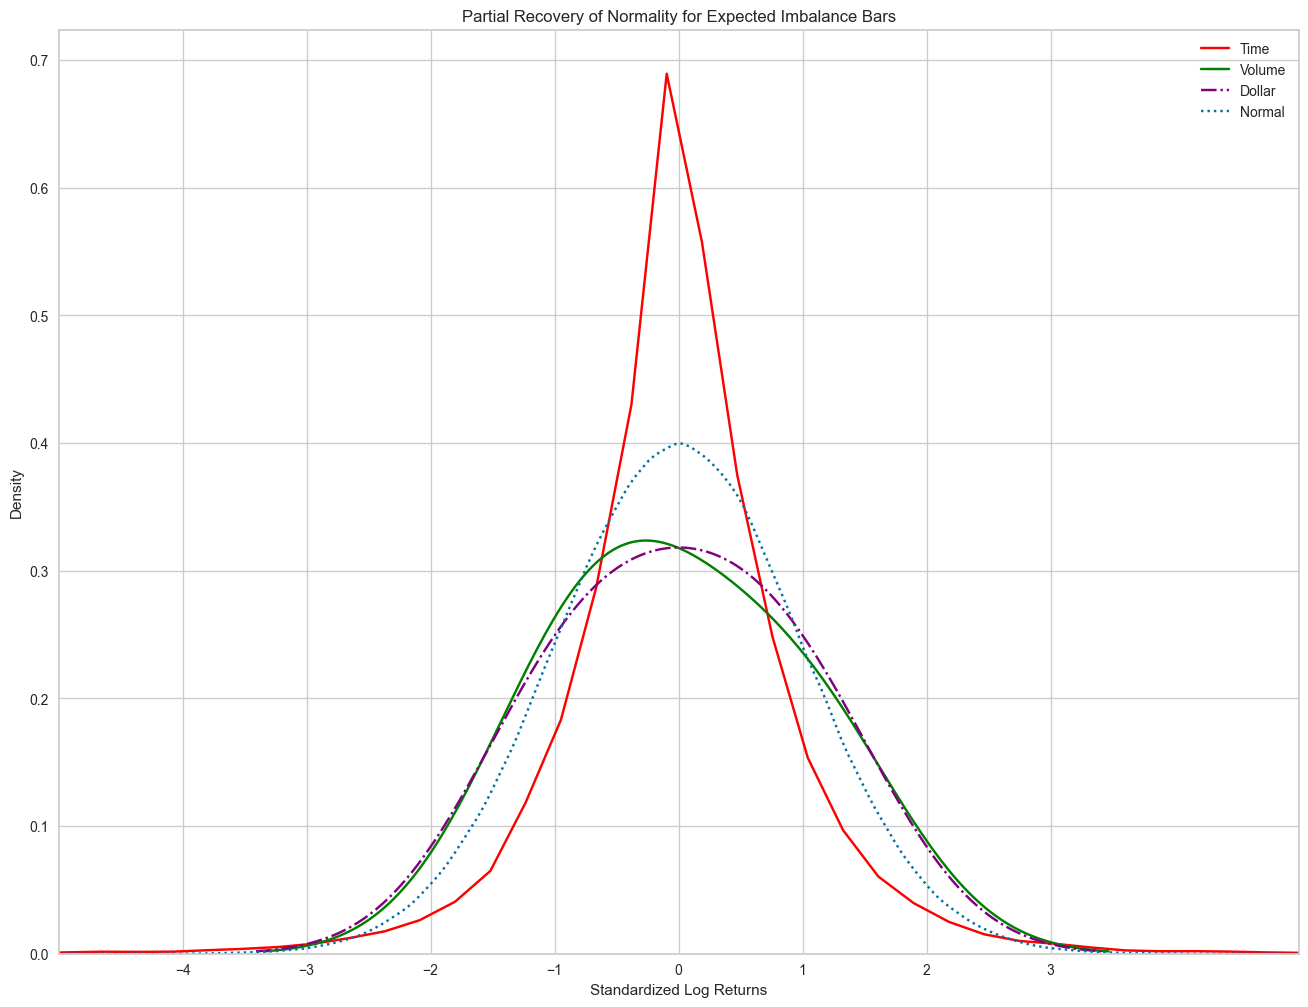

In [33]:
#Distribution Plot
plt.figure(figsize=(16, 12))
sns.kdeplot(time_standard, label="Time", color="red")
sns.kdeplot(EIB_tick_standard, label="Tick", color="blue")
sns.kdeplot(EIB_volume_standard, label="Volume", color="green")
sns.kdeplot(EIB_dollar_standard, label="Dollar", color="purple", linestyle="-.")
sns.kdeplot(np.random.normal(size=1000000), label="Normal", linestyle="dotted")
plt.xticks(range(-4, +4))

#labels
plt.xlabel("Standardized Log Returns")
plt.ylabel("Density")
plt.title(
    'Partial Recovery of Normality for Expected Imbalance Bars',
    loc='center', 
)
plt.xlim(-5, 5)
plt.legend()
plt.show()

## Run Bars

### Tick Run Bars

In [34]:
tick_run_bars = generate_info_driven_bars(sampling_method='expected_tick_run_bars',
                                      df_sample=df_riskAI,
                                      db_best_params=reloaded_db_resampling_params)
tick_run_bars.head()

Processing batch 0 with size 37909


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold


### Volume Run Bars

In [35]:


volume_run_bars = generate_info_driven_bars(sampling_method='expected_volume_run_bars',
                                      df_sample=df_riskAI,
                                      db_best_params=reloaded_db_resampling_params)
volume_run_bars.head()

Processing batch 0 with size 37909


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold


### Dollar Run Bars

In [36]:
dollar_run_bars = generate_info_driven_bars(sampling_method='expected_dollar_run_bars',
                                      df_sample=df_riskAI,
                                      db_best_params=reloaded_db_resampling_params)
dollar_run_bars.head()

Processing batch 0 with size 37909


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold
0,2025-08-22 22:39:56.272676+00:00,7194,118251.351562,118316.007812,111700.000000,116615.562500,40654.294086,20297.769021,20356.525065,7194,4.657780e+09,1.697780e+09
1,2025-08-29 14:08:47.042801+00:00,16757,116583.632812,117029.929688,108692.007812,108740.171875,57014.604967,25904.724602,31109.880364,9563,6.389160e+09,3.478733e+09
2,2025-09-08 14:10:43.702664+00:00,31150,108752.968750,113256.046875,107278.429688,112233.437500,62825.687540,31690.762642,31134.924897,14393,6.925749e+09,3.494400e+09
3,2025-09-12 19:54:32.382654+00:00,37250,112253.992188,116610.992188,110774.023438,116610.992188,33731.296646,17741.869407,15989.427239,6100,3.828365e+09,2.012302e+09


### Statistical Test

#### Log Return

In [37]:
tick_run_bars_returns = log_return(tick_run_bars['Close'])
volume_run_bars_returns = log_return(volume_run_bars['Close'])
dollar_run_bars_returns = log_return(dollar_run_bars['Close'])

####  Jarque–Bera test statistic 

In [ ]:
print("Jarque-Bera test statistic for time returns:", int(stats.jarque_bera(time_returns)[0]))
print("Jarque-Bera test statistic for tick run bars returns:", int(stats.jarque_bera(tick_run_bars_returns)[0]))
print("Jarque-Bera test statistic for volume run bars returns:", int(stats.jarque_bera(volume_run_bars_returns)[0]))
print("Jarque-Bera test statistic for dollar run bars returns:", int(stats.jarque_bera(dollar_run_bars_returns)[0]))

#### Shapiro-Wilk Test

In [ ]:
print("Shapiro-Wilk test statistic for time returns:", stats.shapiro(time_returns))
print("Shapiro-Wilk test statistic for tick run bars returns:", stats.shapiro(tick_run_bars_returns))
print("Shapiro-Wilk test statistic for volume run bars returns:", stats.shapiro(volume_run_bars_returns))
print("Shapiro-Wilk test statistic for dollar run bars returns:", stats.shapiro(dollar_run_bars_returns))

#### Kernel Density Estimate (KDE) plot

In [ ]:
#Standardize Data 
tick_run_bars_standard = (tick_run_bars_returns - tick_run_bars_returns.mean()) / tick_run_bars_returns.std()
volume_run_bars_standard = (volume_run_bars_returns  - volume_run_bars_returns.mean()) / volume_run_bars_returns.std()
dollar_run_bars_standard = (dollar_run_bars_returns - dollar_run_bars_returns.mean()) / dollar_run_bars_returns.std()

In [ ]:
#Distribution Plot
plt.figure(figsize=(16, 12))
sns.kdeplot(time_standard, label="Time", color="red")
sns.kdeplot(tick_run_bars_standard, label="Tick", color="blue")
sns.kdeplot(volume_run_bars_standard, label="Volume", color="green")
sns.kdeplot(dollar_run_bars_standard , label="Dollar", color="purple", linestyle="-.")
sns.kdeplot(np.random.normal(size=1000000), label="Normal", linestyle="dotted")
plt.xticks(range(-4, +4))

#labels
plt.xlabel("Standardized Log Returns")
plt.ylabel("Density")
plt.title(
    'Partial Recovery of Normality for Run Bars',
    loc='center', 
)
plt.xlim(-5, 5)
plt.legend()
plt.show()

# Additional Features

In [39]:
def grouped_features(raw_df, resumpling_df, feature_name, agg_func=np.sum):
    """
    Aggregate a feature between Tick Number ranges using a specified aggregation function.

    Parameters
    ----------
    raw_df : pd.DataFrame
        Full DataFrame with tick-by-tick data.
    resumpling_df : pd.DataFrame
        DataFrame with "Tick Number" boundaries (breakpoints).
    feature_name : str
        Column name in raw_df to aggregate (e.g., "ohlc_trades").
    agg_func : function, default=np.sum
        Aggregation function (e.g., np.sum, np.mean, np.max).

    Returns
    -------
    pd.DataFrame
        resumpling_df with the aggregated feature filled.
    """

    resumpling_df[feature_name] = np.nan  

    m = raw_df[feature_name]
    idx_list = resumpling_df.index.astype(int).to_list()

    if idx_list:
        idx_start = idx_list[0]
        idx_end = idx_list[0] + 1
        resumpling_df.loc[idx_start, feature_name] = agg_func(m.iloc[0:idx_end])

    for start, end in zip(idx_list, idx_list[1:]):
        resumpling_df.loc[end, feature_name] = agg_func(m.iloc[start:(end+1)])

    return resumpling_df

def last_state(raw_df,resumpling_df, feature_name):
    """
    Align the latest state of a feature from the raw dataframe
    onto the resampled dataframe at matching indices.

    Parameters
    ----------
    raw_df : pandas.DataFrame
        Original/raw dataset containing the feature of interest.
    resampling_df : pandas.DataFrame
        Resampled dataset whose index is aligned to raw_df.
    feature_name : str
        Column name (feature) to propagate from raw_df to resampling_df.

    Returns
    -------
    pandas.DataFrame
        Updated resampling_df with a new column `feature_name`
        containing the values from raw_df at matching indices. 

    """

    resumpling_df[feature_name] = np.nan  
    idx_list = resumpling_df.index.to_list()
    for i in idx_list:
        resumpling_df.loc[i,feature_name] = raw_df[feature_name][i]
    return resumpling_df

def price_vwap(raw_df, resumpling_df, feature_name, vol_colum_name ='ohlc_volume'):
    """
    Compute VWAP (Volume-Weighted Average Price) for each resampled bar.

    Parameters
    ----------
    raw_df : pandas.DataFrame
        Original dataframe with price and volume data.
    resampling_df : pandas.DataFrame
        Resampled dataframe that defines the bar boundaries (by index).
    feature_name : str
        Column name in raw_df containing prices to weight.
    vol_column_name : str, default="ohlc_volume"
        Column name in raw_df containing volume weights.

    Returns
    -------
    pandas.DataFrame
        Updated resampling_df with an extra column containing VWAP values
        for each resampled interval.
    """
    
    resumpling_df[feature_name] = np.nan  

    m = raw_df[feature_name]
    vol = raw_df[vol_colum_name]

    idx_list = resumpling_df.index.astype(int).to_list()

    if idx_list:
        idx_start = idx_list[0]
        idx_end = idx_list[0] + 1

        resumpling_df.loc[idx_start, feature_name] = np.average(m[0:idx_end], weights=vol[0:idx_end])

    for start, end in zip(idx_list, idx_list[1:]):
        resumpling_df.loc[end, feature_name] = np.average(m[start:(end+1)], weights=vol[start:(end+1)])

    return resumpling_df

In [40]:
def aggregate_features(input_df, sampling_df):

    """
    Aggregate raw features into resampled bars using different strategies.

    Parameters
    ----------
    input_df : pandas.DataFrame
        Raw tick-level dataframe containing all features.
    sampling_df : pandas.DataFrame
        DataFrame with resampled bar boundaries.
        Must contain a 'Tick Number' column to align with input_df.

    Returns
    -------
    pandas.DataFrame
        Updated sampling_df containing aggregated features.
    """

    sampling_df =sampling_df.set_index("Tick Number")

    vol_sum = ['ohlc_trades','ohlc_taker_base','ohlc_taker_quote',
            'tr_volume_base','tr_volume_quote']

    last_states = ['l1_bid','l1_ask','l1_mid','l1_spread',
                'l1_bid_qty','l1_ask_qty','l1_imbalance',
                'l2_bid_depth','l2_ask_depth','l2_depth_asymmetry',
                'l2_bid_vwap','l2_ask_vwap','l2_bid_slope','l2_ask_slope',
                'spot_price','perp_mark_price','basis_abs','basis_pct',
                'funding_rate','next_funding_time_ms']

    mean_bar= ['tr_buy_sell_imbalance']

    weighted_mean = ['tr_vwap']

    #total
    for i in vol_sum:
        sampling_df  = grouped_features(raw_df=input_df, 
                                        resumpling_df=sampling_df , 
                                        feature_name=i, 
                                        agg_func=np.sum)
    #last value
    for j in last_states:
        sampling_df  = last_state(raw_df=input_df,
                                    resumpling_df=sampling_df ,
                                    feature_name=j)
    #average value   
    for k in mean_bar:
        sampling_df  = grouped_features(raw_df=input_df, 
                                        resumpling_df=sampling_df , 
                                        feature_name=k, 
                                        agg_func=np.mean)
    #weighted average
    for _ in weighted_mean:
        sampling_df  = price_vwap(raw_df=input_df, 
                                    resumpling_df=sampling_df , 
                                    feature_name= _,
                                    vol_colum_name ='ohlc_volume')
        
    return sampling_df

In [41]:
df_features = aggregate_features(input_df=df, sampling_df=dollar_run_bars)
df_features

,Date Time,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,...,l2_bid_slope,l2_ask_slope,spot_price,perp_mark_price,basis_abs,basis_pct,funding_rate,next_funding_time_ms,tr_buy_sell_imbalance,tr_vwap
Tick Number,,,,,,,,,,,,,,,,,,,,,
7194,2025-08-22 22:39:56.272676+00:00,118251.351562,118316.007812,111700.000000,116615.562500,40654.294086,20297.769021,20356.525065,7194,4.657780e+09,...,-17.814844,3.227623,116583.617188,116540.296875,-43.320000,-0.000372,0.000100,1.755907e+12,-0.035910,114524.781250
16757,2025-08-29 14:08:47.042801+00:00,116583.632812,117029.929688,108692.007812,108740.171875,57014.604967,25904.724602,31109.880364,9563,6.389160e+09,...,-49.723106,1.319228,108720.359375,108703.531250,-16.825142,-0.000155,0.000014,1.756483e+12,-0.036090,112181.765625
31150,2025-09-08 14:10:43.702664+00:00,108752.968750,113256.046875,107278.429688,112233.437500,62825.687540,31690.762642,31134.924897,14393,6.925749e+09,...,-2.260226,2.333816,112253.976562,112217.179688,-36.803734,-0.000328,0.000100,1.757347e+12,-0.054070,110217.695312
37250,2025-09-12 19:54:32.382654+00:00,112253.992188,116610.992188,110774.023438,116610.992188,33731.296646,17741.869407,15989.427239,6100,3.828365e+09,...,-5.199858,73.841431,116657.562500,116594.250000,-63.310051,-0.000543,-0.000001,1.757722e+12,-0.089403,113474.515625
